In [1]:
import time
import random
import sys
import os
import gym
from gym.envs.toy_text import blackjack
from IPython.display import clear_output
import pdb
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')

Set up

In [2]:
env = gym.make('Blackjack-v1',new_step_api=True)
env.reset()
print(f'Action space: {env.action_space}. \n\n=> (1 = Hit, 0 = Bust)\n')
print('-----------------------------------------------\n')
print(f'Observation space: {env.observation_space} \n\n=> (Player hand sum, Dealer card, Usable ace)')

Action space: Discrete(2). 

=> (1 = Hit, 0 = Bust)

-----------------------------------------------

Observation space: Tuple(Discrete(32), Discrete(11), Discrete(2)) 

=> (Player hand sum, Dealer card, Usable ace)


Random test

In [11]:
def play_random(env, episodes=1000):
    wins, draws, losses = 0, 0, 0
    total_reward = 0

    for _ in range(episodes):
        state = env.reset()
        done = False

        while not done:
            action = env.action_space.sample()  # Choose random action
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

        total_reward += reward

        if reward > 0:
            wins += 1
        elif reward < 0:
            losses += 1
        else:
            draws += 1

    avg_reward = total_reward / episodes
    print(f"Random Play - Wins: {wins}, Draws: {draws}, Losses: {losses}, Average Reward: {avg_reward:.4f}")
play_random(env)

Random Play - Wins: 258, Draws: 37, Losses: 705, Average Reward: -0.4470


Q-learning

In [50]:
env = gym.make('Blackjack-v1',new_step_api=True)
Q = {}

for player_sum in range(4, 33):
    for dealer_show in range(1, 11):
        for usable_ace in [True, False]:
            Q[(player_sum, dealer_show, usable_ace)] = [0, 0]  # 0: hit, 1: stick

alpha = 0.1
gamma = 0.99
epsilon = 0.1
episodes = 1000

rewards_per_episode = []
episode_lengths = []

def epsilon_greedy(state):
    if random.uniform(0, 1) < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q[state])

for episode in range(episodes):
    state = env.reset()
    state = (state[0], state[1], state[2])
    done = False
    total_reward = 0
    steps = 0
    while not done:
        action = epsilon_greedy(state)
        next_state, reward,terminated, truncated, _ = env.step(action)
        done= terminated or truncated
        next_state = (next_state[0], next_state[1], next_state[2])

        if next_state[0] > 32:
            next_state = (32, next_state[1], next_state[2])

        current_q = Q[state][action]
        max_next_q = max(Q[next_state])

        Q[state][action] = current_q + alpha * (reward + gamma * max_next_q - current_q)
        state = next_state
        total_reward += reward
        steps += 1
    rewards_per_episode.append(total_reward)
    episode_lengths.append(steps)
    # 每1000个回合打印一次进度
    if episode % 1000 == 0:
        print(f"Episode {episode}/{episodes}")

print("训练完成！")


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0/1000
训练完成！


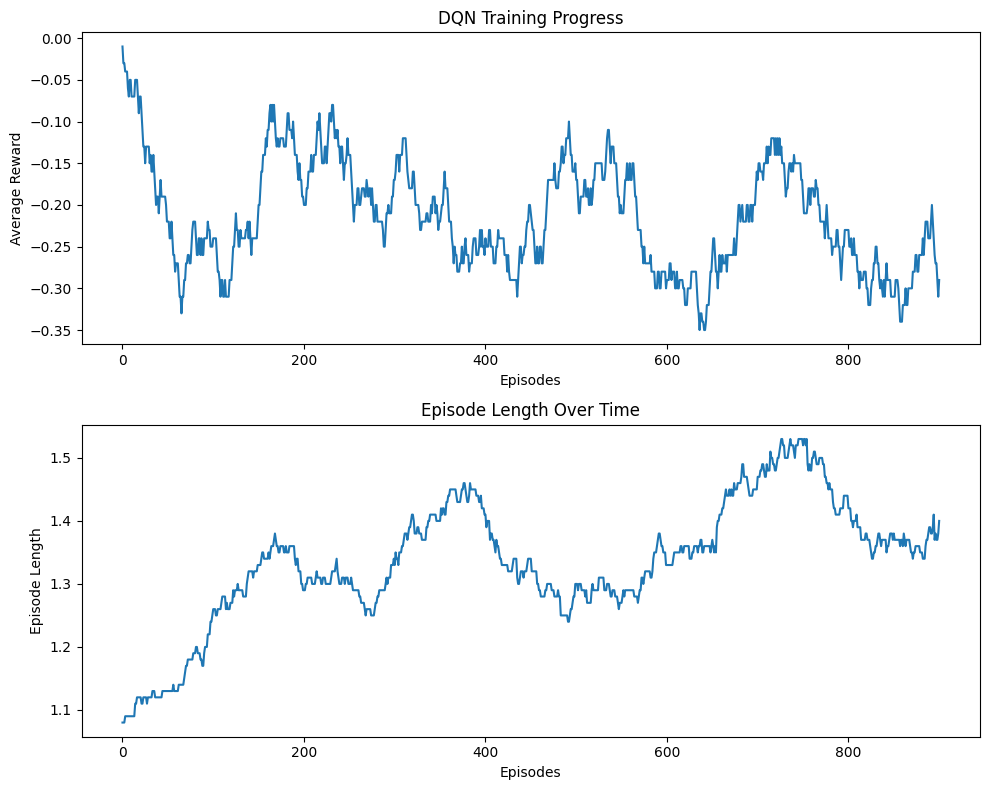

In [51]:
def plot_training_results():
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    def smooth(data, window=100):
        return np.convolve(data, np.ones(window) / window, mode='valid')

    axs[0].plot(smooth(rewards_per_episode))
    #axs[0].plot(rewards_per_episode)
    axs[0].set_xlabel('Episodes')
    axs[0].set_ylabel('Average Reward')
    axs[0].set_title('DQN Training Progress')

    axs[1].plot(smooth(episode_lengths))
    axs[1].set_xlabel('Episodes')
    axs[1].set_ylabel('Episode Length')
    axs[1].set_title('Episode Length Over Time')

    plt.tight_layout()
    plt.show()

plot_training_results()

In [52]:
def play_blackjack(Q, env, episodes=1000):
    wins, draws, losses = 0, 0, 0
    total_reward = 0
    for _ in range(episodes):
        state = env.reset()
        done = False

        while not done:
            action = np.argmax(Q[state])  # Choose best action
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
        total_reward += reward
        if reward > 0:
            wins += 1
        elif reward < 0:
            losses += 1
        else:
            draws += 1
    avg_reward = total_reward / episodes

    print(f"Wins: {wins}, Draws: {draws}, Losses: {losses},Average Reward: {avg_reward:.4f}")

In [53]:
play_blackjack(Q, env)

Wins: 356, Draws: 71, Losses: 573,Average Reward: -0.2170


In [58]:
import seaborn as sns
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D
def visualize_policy(Q):
    dealer_range = range(1, 11)  # Dealer's showing card (1-10)
    player_range = range(12, 22)  # Player's hand sum (12-21)
    usable_ace = False  # Use `True` if you want to consider usable ace, else `False`

    player_count, dealer_count = np.meshgrid(player_range, dealer_range)
    value = np.apply_along_axis(
        lambda obs: float(np.max([Q.get((obs[0], obs[1], False), [0, 0])[0],  # Get value for action 0 (hit)
                                    Q.get((obs[0], obs[1], True), [0, 0])[0]])), # Get value for action 0 (hit) with usable ace
                                    #Q.get((obs[0], obs[1], False), [0, 0])[1]])), # Get value for action 1 (stick) # This is causing error
                                    #Q.get((obs[0], obs[1], True), [0, 0])[1]])), # Get value for action 1 (stick) with usable ace # This is causing error
        axis=2,
        arr=np.dstack([player_count, dealer_count])
    )

    policy = np.apply_along_axis(
        lambda obs: int(np.argmax([Q.get((obs[0], obs[1], False), [0, 0])[0],  # Get value for action 0 (hit)
                                    Q.get((obs[0], obs[1], True), [0, 0])[0]])), # Get value for action 0 (hit) with usable ace
                                    #Q.get((obs[0], obs[1], False), [0, 0])[1]])), # Get value for action 1 (stick) # This is causing error
                                    #Q.get((obs[0], obs[1], True), [0, 0])[1]])), # Get value for action 1 (stick) with usable ace # This is causing error
        axis=2,
        arr=np.dstack([player_count, dealer_count])
    )

    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle('Policy Visualization:Q-learning', fontsize=16)

    # 3D plot
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    ax1.set_xlabel("Player Sum")
    ax1.set_ylabel("Dealer Showing")
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.set_title("State Values")
    ax1.view_init(20, 220)

    # 2D policy plot
    ax2 = fig.add_subplot(1, 2, 2)
    cmap = sns.color_palette(['grey', 'lightgreen'], as_cmap=True)
    sns.heatmap(policy, linewidth=0, annot=True, cmap=cmap, cbar=False)
    ax2.set_xlabel("Player Sum")
    ax2.set_ylabel("Dealer Showing")
    ax2.set_xticks(np.arange(10) + 0.5)
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticks(np.arange(10) + 0.5)
    ax2.set_yticklabels(['A'] + list(range(2, 11)), fontsize=12)
    ax2.set_title("Policy: Green = Hit, Grey = Stick")

    legend_elements = [
        Patch(facecolor='lightgreen', edgecolor='black', label='Hit'),
        Patch(facecolor='grey', edgecolor='black', label='Stick')
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))

    plt.show()

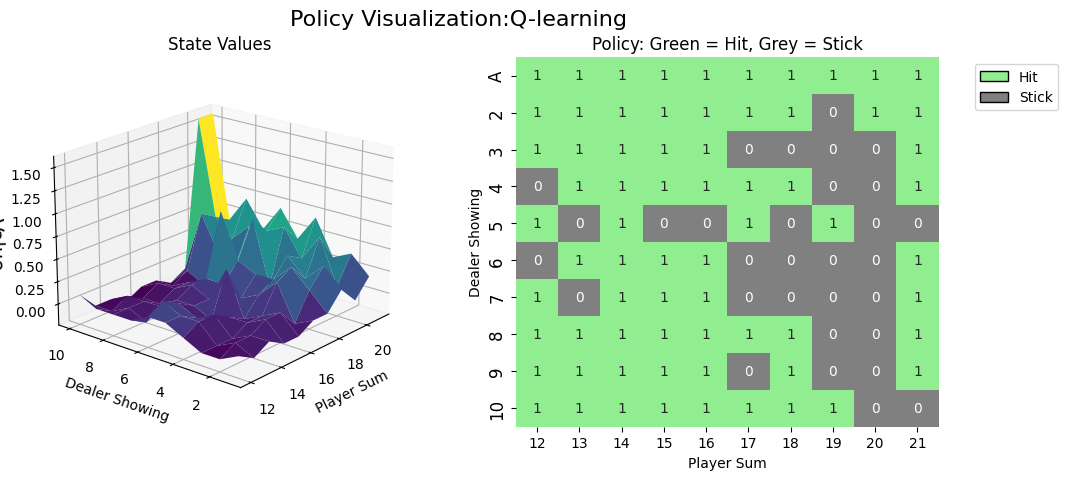

In [59]:
visualize_policy(Q)

Deep Q-learning

In [61]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [62]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.array(state), np.array(action), np.array(reward), np.array(next_state), np.array(done)

    def __len__(self):
        return len(self.buffer)

In [63]:
import random
from collections import deque
class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        self.policy_net = DQN(state_dim, action_dim)
        self.target_net = DQN(state_dim, action_dim)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

        self.buffer = ReplayBuffer(10000)

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1)
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state)
                q_values = self.policy_net(state)
                return torch.argmax(q_values).item()

    def update(self, batch_size):
        if len(self.buffer) < batch_size:
            return

        state, action, reward, next_state, done = self.buffer.sample(batch_size)
        state = torch.FloatTensor(state)
        action = torch.LongTensor(action)
        reward = torch.FloatTensor(reward)
        next_state = torch.FloatTensor(next_state)
        done = torch.FloatTensor(done)

        current_q = self.policy_net(state).gather(1, action.unsqueeze(1))

        with torch.no_grad():
            next_q = self.target_net(next_state).max(1)[0]
            target_q = reward + (1 - done) * self.gamma * next_q

        # 计算损失并更新网络
        loss = self.loss_fn(current_q.squeeze(), target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # 更新 epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def update_target_net(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

In [64]:
env = gym.make('Blackjack-v1')
state_dim = 3  # player_sum, dealer_show, usable_ace
action_dim = 2  # 0: stick, 1: hit

agent = DQNAgent(state_dim, action_dim)
batch_size = 64
num_episodes = 1000
update_target_every = 10

rewards_per_episode = []
episode_lengths = []
training_errors = []
def train_blackjack_agent(agent, env, episodes=1000):
  for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    steps = 0
    while True:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.buffer.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        agent.update(batch_size)
        steps += 1
        if done:
            break
    rewards_per_episode.append(total_reward)
    episode_lengths.append(steps)
    #training_errors.append(agent.get_loss())
    if episode % update_target_every == 0:
        agent.update_target_net()

    if episode % 100 == 0:
        print(f"Episode {episode}/{num_episodes}, Total Reward: {total_reward:.2f}")

train_blackjack_agent(agent,env)


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0/1000, Total Reward: -1.00
Episode 100/1000, Total Reward: 1.00
Episode 200/1000, Total Reward: -1.00
Episode 300/1000, Total Reward: 1.00
Episode 400/1000, Total Reward: 0.00
Episode 500/1000, Total Reward: -1.00
Episode 600/1000, Total Reward: 1.00
Episode 700/1000, Total Reward: -1.00
Episode 800/1000, Total Reward: -1.00
Episode 900/1000, Total Reward: 0.00


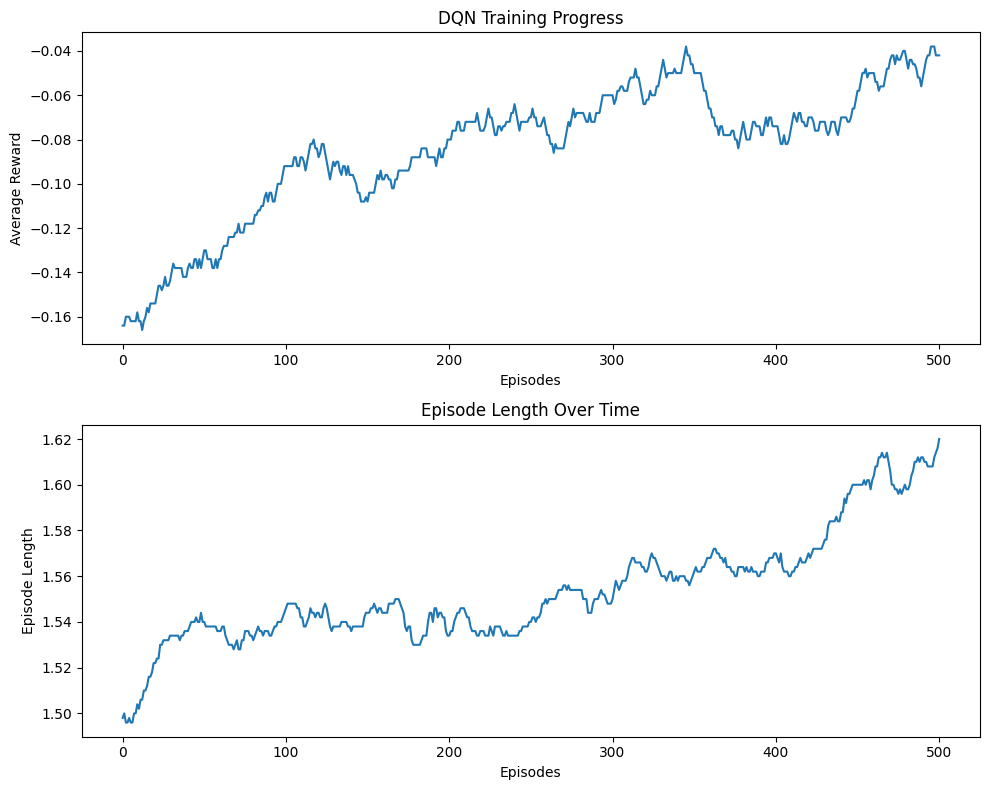

In [65]:
def plot_training_results():
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    def smooth(data, window=500):
        return np.convolve(data, np.ones(window) / window, mode='valid')

    axs[0].plot(smooth(rewards_per_episode))
    axs[0].set_xlabel('Episodes')
    axs[0].set_ylabel('Average Reward')
    axs[0].set_title('DQN Training Progress')

    axs[1].plot(smooth(episode_lengths))
    axs[1].set_xlabel('Episodes')
    axs[1].set_ylabel('Episode Length')
    axs[1].set_title('Episode Length Over Time')

    #axs[2].plot(smooth(training_errors))
    #axs[2].set_xlabel('Episodes')
    #axs[2].set_ylabel('Training Error')
    #axs[2].set_title('Training Error Over Time')

    plt.tight_layout()
    plt.show()

plot_training_results()

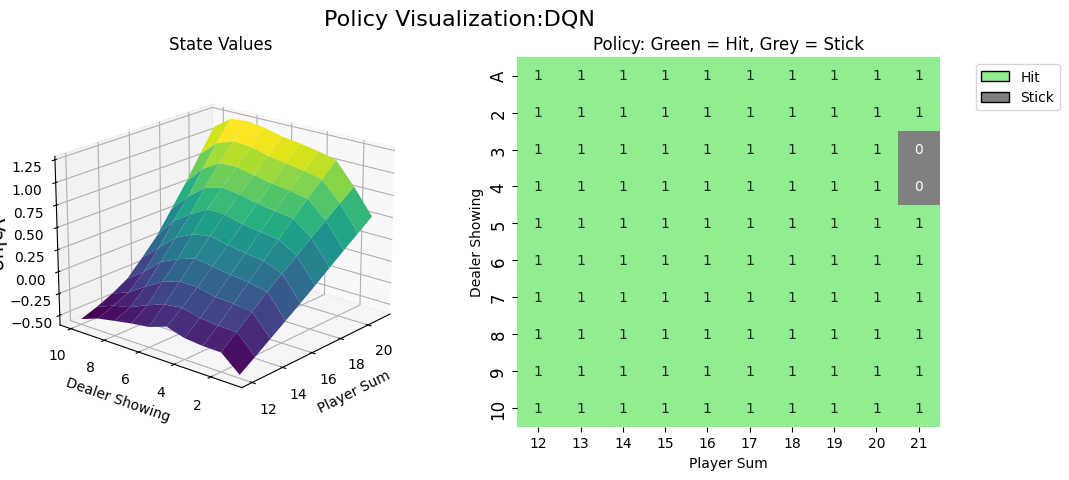

In [68]:
def visualize_policy_agent(agent): # Change Q to agent
    dealer_range = range(1, 11)  # Dealer's showing card (1-10)
    player_range = range(12, 22)  # Player's hand sum (12-21)

    player_count, dealer_count = np.meshgrid(player_range, dealer_range)

    # Modify to use agent.policy_net for getting Q values
    value = np.zeros_like(player_count, dtype=float)
    policy = np.zeros_like(player_count, dtype=int)

    for i in range(player_count.shape[0]):
        for j in range(player_count.shape[1]):
            player_sum = player_count[i, j]
            dealer_show = dealer_count[i, j]

            # Get Q-values from the policy network
            state = torch.FloatTensor([player_sum, dealer_show, 0]) # Usable ace = False
            q_values_no_ace = agent.policy_net(state).detach().numpy()

            state = torch.FloatTensor([player_sum, dealer_show, 1]) # Usable ace = True
            q_values_ace = agent.policy_net(state).detach().numpy()

            # Choose best action and corresponding value
            best_action = np.argmax([q_values_no_ace[0], q_values_ace[0]])
                                                           # Considering only 'hit' action as causing error with stick
                                                           # [q_values_no_ace[0],q_values_no_ace[1], q_values_ace[0],q_values_ace[1]] ) #For both action
            value[i, j] = np.max([q_values_no_ace[0], q_values_ace[0]])
                                                            # Considering only 'hit' action as causing error with stick
                                                            # [q_values_no_ace[0],q_values_no_ace[1], q_values_ace[0],q_values_ace[1]] ) #For both action
            policy[i, j] = best_action

    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle('Policy Visualization:DQN', fontsize=16)

    # 3D plot
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    ax1.set_xlabel("Player Sum")
    ax1.set_ylabel("Dealer Showing")
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.set_title("State Values")
    ax1.view_init(20, 220)

    # 2D policy plot
    ax2 = fig.add_subplot(1, 2, 2)
    cmap = sns.color_palette(['grey', 'lightgreen'], as_cmap=True)
    sns.heatmap(policy, linewidth=0, annot=True, cmap=cmap, cbar=False)
    ax2.set_xlabel("Player Sum")
    ax2.set_ylabel("Dealer Showing")
    ax2.set_xticks(np.arange(10) + 0.5)
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticks(np.arange(10) + 0.5)
    ax2.set_yticklabels(['A'] + list(range(2, 11)), fontsize=12)
    ax2.set_title("Policy: Green = Hit, Grey = Stick")

    legend_elements = [
        Patch(facecolor='lightgreen', edgecolor='black', label='Hit'),
        Patch(facecolor='grey', edgecolor='black', label='Stick')
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))

    plt.show()
visualize_policy_agent(agent)

In [69]:
def play_blackjack_agent(agent, env, episodes=1000): # Changed Q to agent
    wins, draws, losses = 0, 0, 0
    total_reward = 0
    for _ in range(episodes):
        state = env.reset()
        done = False

        while not done:
            action = agent.select_action(state)  # Use agent.select_action to choose the action
            state, reward, done, _ = env.step(action)
            #done = terminated or truncated
        total_reward += reward
        if reward > 0:
            wins += 1
        elif reward < 0:
            losses += 1
        else:
            draws += 1
    avg_reward = total_reward / episodes

    print(f"Wins: {wins}, Draws: {draws}, Losses: {losses},Average Reward: {avg_reward:.4f}")
play_blackjack_agent(agent,env)

Wins: 419, Draws: 86, Losses: 495,Average Reward: -0.0760
